In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
import pickle
import requests
import numpy as np
from glicko2 import Glicko2
from trueskill import TrueSkill
from scipy.stats import norm
from collections import defaultdict
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["figure.titlesize"] = 20

## Load data

In [2]:
df = pd.read_csv('data_preprocessed.csv', parse_dates=['Date'])

In [3]:
# get a dictionary lookup with team id and the day before the team first played. this is the day that we will set the initial rating on

teams = pd.melt(df[['winner', 'loser', 'Date']], value_vars=['winner', 'loser'], id_vars='Date', value_name='team', var_name='status')
all_teams = teams.team.unique()

## Elo

In [4]:
# write two functions: one that calculates the expected win probability and one that updates the rating
# remember you also need an initial rating value

def expected(a, b, n=400) -> float:
    return 1 / (1 + 10 ** ((b-a) / n))

def update(current, expected, outcome, k=10) -> float:
    return current + k * (outcome - expected)

In [5]:
def rate_elo(n=400, k=10, init_rating=1200):
    ratings = dict()
    for t in all_teams:
        ratings[t] = {'date': [], 'rating': []}
    for row in df.itertuples():
        loser = row.loser
        winner = row.winner
        date = row.Date
        try:
            old_rating_winner = ratings[winner]['rating'][-1]
        except IndexError:
            old_rating_winner = init_rating
        try:
            old_rating_loser = ratings[loser]['rating'][-1]
        except IndexError:
            old_rating_loser = init_rating
        exp_winner = expected(old_rating_winner, old_rating_loser, n)
        exp_loser = expected(old_rating_loser, old_rating_winner, n)
        if row.draw:
            rating_winner = update(old_rating_winner, exp_winner, 0.5, k)
            rating_loser = update(old_rating_loser, exp_loser, 0.5, k)
        else:
            rating_winner = update(old_rating_winner, exp_winner, 1, k)
            rating_loser = update(old_rating_loser, exp_loser, 0, k)
        ratings[winner]['rating'].append(rating_winner)
        ratings[winner]['date'].append(date)        
        ratings[loser]['rating'].append(rating_loser)
        ratings[loser]['date'].append(date)
    return ratings

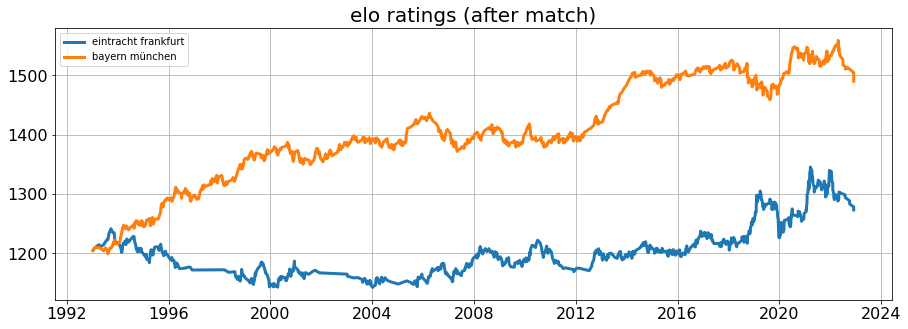

In [6]:
# plotting time: let's look at some teams over time!
ratings = rate_elo(n=400, k=10, init_rating=1200)
fig, ax = plt.subplots()
plt.plot(ratings['einfrankfurt']['date'], ratings['einfrankfurt']['rating'], label='eintracht frankfurt')
plt.plot(ratings['bayernmunich']['date'], ratings['bayernmunich']['rating'], label='bayern münchen')
plt.legend()
_ = plt.title('elo ratings (after match)')

## Testing Elo quality

- We don't need a test set
- Careful about calibration time

In [7]:
# write a function for the brier score

# could also use the one in sklearn.metrics
def brier_score(preds: list, outs: list) -> float:
    return np.average((outs - preds) ** 2)

In [8]:
def get_rating_on_date(rating_dict, team, date, init_rating=1200):
    # todo: how do we manage ratings during calibration period?
    # since we stored the ratings AFTER the match, we always need to use the one before that day
    date_idx = rating_dict[team]['date'].index(date)
    if date_idx >= 1:
        return rating_dict[team]['rating'][date_idx - 1]
    else:
        return init_rating

In [9]:
elo_predictions = []
for winner, loser, date in zip(df.winner.values, df.loser.values, df.Date.values):
    winner_rating = get_rating_on_date(ratings, winner, date)
    loser_rating = get_rating_on_date(ratings, loser, date)
    elo_predictions.append(expected(winner_rating, loser_rating, n=400))

In [10]:
brier_score(elo_predictions, np.ones(len(elo_predictions))-0.5*df.draw)

0.16900417566328027

In [11]:
# tuning time!